<a href="https://colab.research.google.com/github/cloudui/ml-by-example/blob/main/ch2/ch2_NB_movie_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation Engine Using Naive Bayes


## File download and organization

In [3]:
import urllib.request

In [4]:
urllib.request.urlretrieve('https://files.grouplens.org/datasets/movielens/ml-1m.zip', 'data.zip')

('data.zip', <http.client.HTTPMessage at 0x7ff963279f10>)

In [5]:
!unzip data.zip
!rm data.zip

Archive:  data.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


## Data preprocessing

In [6]:
import numpy as np
from collections import defaultdict

In [7]:
data_path = 'ml-1m/ratings.dat'
n_users = 6040
n_movies = 3706

In [8]:
def load_rating_data(data_path, n_users, n_movies):

  data = np.zeros([n_users, n_movies], dtype=np.float32)
  movie_id_mapping = {}

  movie_n_rating = defaultdict(int)

  with open(data_path, 'r') as file:
    for line in file.readlines()[1: ]:
      user_id, movie_id, rating, _ = line.split("::")
      user_id = int(user_id) - 1
      if movie_id not in movie_id_mapping:
        movie_id_mapping[movie_id] = len(movie_id_mapping)
      rating = int(rating)
      data[user_id, movie_id_mapping[movie_id]] = rating
      if rating > 0:
        movie_n_rating[movie_id] += 1
  return data, movie_n_rating, movie_id_mapping

In [9]:
data, movie_n_rating, movie_id_mapping = load_rating_data(data_path, n_users, n_movies)

In [10]:
def display_distribution(data):
  values, counts = np.unique(data, return_counts=True)
  for value, count in zip(values, counts):
    print(f'Number of rating {int(value)}: {count}')

In [11]:
display_distribution(data)

Number of rating 0: 21384032
Number of rating 1: 56174
Number of rating 2: 107557
Number of rating 3: 261197
Number of rating 4: 348971
Number of rating 5: 226309


In [12]:
movie_id_most, n_rating_most = sorted(movie_n_rating.items(), key = lambda d: d[1], reverse=True)[0]
print(f'Movie ID {movie_id_most} has {n_rating_most} ratings.')

Movie ID 2858 has 3428 ratings.


In [13]:
X_raw = np.delete(data, movie_id_mapping[movie_id_most], axis=1)
Y_raw = data[:, movie_id_mapping[movie_id_most]]

In [14]:
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]

In [15]:
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

Shape of X: (3428, 3705)
Shape of Y: (3428,)


In [16]:
display_distribution(Y)

Number of rating 1: 83
Number of rating 2: 134
Number of rating 3: 358
Number of rating 4: 890
Number of rating 5: 1963


In [17]:
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1
n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()

print(f'{n_pos} positive samples and {n_neg} negative samples.')

2853 positive samples and 575 negative samples.


## Model Training

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(Y_train), len(Y_test))

2742 686


In [20]:
from sklearn.naive_bayes import MultinomialNB

In [21]:
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)

MultinomialNB()

In [22]:
prediction_prob = clf.predict_proba(X_test)

In [23]:
prediction_prob[0:10]

array([[7.50487439e-23, 1.00000000e+00],
       [1.01806208e-01, 8.98193792e-01],
       [3.57740570e-10, 1.00000000e+00],
       [1.00000000e+00, 2.94095407e-16],
       [1.00000000e+00, 2.49760836e-25],
       [7.62630220e-01, 2.37369780e-01],
       [3.47479627e-05, 9.99965252e-01],
       [2.66075292e-11, 1.00000000e+00],
       [5.88493563e-10, 9.99999999e-01],
       [9.71326867e-09, 9.99999990e-01]])

In [24]:
prediction = clf.predict(X_test)
prediction[0:10]

array([1., 1., 1., 0., 0., 0., 1., 1., 1., 1.], dtype=float32)

## Metrics and Results of Model

In [25]:
accuracy = clf.score(X_test, Y_test)
print(f'The accuracy of the model is: {accuracy*100:.1f}%')

The accuracy of the model is: 71.6%


In [26]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [27]:
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))
print(precision_score(Y_test, prediction, pos_label=1))
print(recall_score(Y_test, prediction, pos_label=1))
print(f1_score(Y_test, prediction, pos_label=1))

[[ 60  47]
 [148 431]]
0.9016736401673641
0.7443868739205527
0.815515610217597


In [28]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

         0.0       0.29      0.56      0.38       107
         1.0       0.90      0.74      0.82       579

    accuracy                           0.72       686
   macro avg       0.60      0.65      0.60       686
weighted avg       0.81      0.72      0.75       686



In [29]:
pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.1, 0.05)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
  for i, threshold in enumerate(thresholds):
    if pred >= threshold:
      if y == 1:
        true_pos[i] += 1
      else:
        false_pos[i] += 1
    else:
      break

In [30]:
n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()

In [31]:
true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]

No handles with labels found to put in legend.


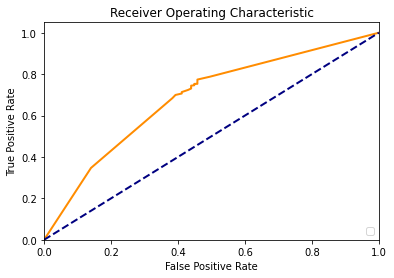

In [32]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [33]:
# 0 percent happening when the threshold is 1.05 (impossible)

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, pos_prob)

0.6857375752586637

# Tuning models with cross-validation

In [35]:
from sklearn.model_selection import StratifiedKFold
k = 5
k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

In [36]:
smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False]
auc_record = {}

In [37]:
for train_indices, test_indices in k_fold.split(X, Y):
  X_train, X_test = X[train_indices], X[test_indices]
  Y_train, Y_test = Y[train_indices], Y[test_indices]
  for alpha in smoothing_factor_option:
    if alpha not in auc_record:
      auc_record[alpha] = {}
    for fit_prior in fit_prior_option:
      clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
      clf.fit(X_train, Y_train)
      prediction_prob = clf.predict_proba(X_test)
      pos_prob = prediction_prob[:, 1]
      auc = roc_auc_score(Y_test, pos_prob)
      auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)


In [45]:
items = []
for smoothing, smoothing_record in auc_record.items():
  for fit_prior, auc in smoothing_record.items():
    items.append((fit_prior, auc, smoothing))
    print(f'{smoothing}     {str(fit_prior):10}  {auc/k:.5f}') 

1     True        0.65280
1     False       0.65274
2     True        0.65108
2     False       0.65274
3     True        0.65313
3     False       0.65322
4     True        0.65397
4     False       0.65430
5     True        0.65455
5     False       0.65448
6     True        0.65478
6     False       0.65404


In [46]:
best_auc = sorted(items, key= lambda x: x[1])[-1]
best_alpha = best_auc[2]
best_fit = best_auc[0]

clf = MultinomialNB(alpha=best_alpha, fit_prior=best_fit)
clf.fit(X_train, Y_train)
pos_prob = clf.predict_proba(X_test)[:, 1]
print('AUC with the best model:', roc_auc_score(Y_test, pos_prob))

AUC with the best model: 0.6492982456140352
